# Manual Testing

This file is designed to load in the saved models trained by main.py and evaluate them

In [1]:
import sys
sys.path.append('..')
from a2c_ppo_acktr import algo, utils
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from evaluation import evaluate
from tqdm import tqdm

import matplotlib.pyplot as plt

def load_model(algo='ppo', env=None, filename=None):
    '''
    Load a trained model from the algorithm
    '''
    if env is None and filename is None:
        raise
    file = 'trained_models/' + algo + '/'
    if env is not None:
        file = file + env + '.pt'
    elif filename is not None:
        file = file + filename
        
    model, rms = torch.load(file)

    return model, rms
    
%run model_evaluation

# Test running a single model and running Policy, FlexBase

In [ ]:
%run model_evaluation

model, obs_rms, kwargs = load_model_and_env('nav_auxiliary_tasks/nav_c4_auxwall1', 0)

action_randomizer = lambda step: np.random.choice([0, 1, 2])
results = forced_action_evaluate(model, obs_rms, forced_actions=action_randomizer, env_kwargs=kwargs, 
                                data_callback=nav_data_callback, num_episodes=1, with_activations=True)


obs, rnn_hxs, masks = results['obs'][0], results['hidden_states'][0], results['masks'][0]

import sys
sys.path.append('../')
from a2c_ppo_acktr.model import Policy

env = gym.make('NavEnv-v0', **kwargs)

model = Policy(obs.squeeze().shape, env.action_space, base='FlexBase', base_kwargs={'num_shared_layers': 0, 'auxiliary_heads': [[-1, 0, 1]]})
# model = Policy(obs.squeeze().shape, env.action_space, base='FlexBase', base_kwargs={'num_shared_layers': 0})

# model, obs_rms, kwargs = load_model_and_env('nav_invisible_shared/nav_c4_shared0.dist', 0)
action_randomizer = lambda step: np.random.choice([0, 1, 2])
results = forced_action_evaluate(model, obs_rms, forced_actions=action_randomizer, env_kwargs=kwargs, 
                                data_callback=nav_data_callback, num_episodes=1, with_activations=True)


In [6]:
model, obs_rms, kwargs = load_model_and_env('nav_auxiliary_tasks2/nav_c4_auxeuclid0', 0)
env = gym.make('NavEnv-v0', **kwargs)

In [18]:
def quick_vec_env(obs_rms, env_kwargs={}, env_name='NavEnv-v0', seed=0,
                 num_processes=1, eval_log_dir='/tmp/gym/_eval',
                 device=torch.device('cpu'), capture_video=False):
    eval_envs = make_vec_envs(env_name, seed + num_processes, num_processes,
                          None, eval_log_dir, device, True, 
                          capture_video=capture_video, 
                          env_kwargs=env_kwargs)

    vec_norm = utils.get_vec_normalize(eval_envs)
    if vec_norm is not None:
        vec_norm.eval()
        vec_norm.obs_rms = obs_rms
        
    return eval_envs


In [10]:
obs = []
for i in tqdm(range(50000)):
    obs.append(env.reset())

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:37<00:00, 1341.25it/s]


In [19]:
envs = quick_vec_env(obs_rms, kwargs, num_processes=16)

In [20]:
envs.reset()



In [27]:
output = envs.step(act)

In [25]:
act = torch.tensor(np.full(16, 1).reshape(-1, 1))

In [29]:
output[0].shape

torch.Size([16, 60])

In [128]:
all_obs = []
for i in tqdm(range(10000)):
    if i % 3 == 0:
        envs.reset()
    
    output = envs.step(act)
    all_obs.append(output[0])
    


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 275.37it/s]


In [129]:
all_obs2 = np.vstack(all_obs)
print(np.isnan(all_obs2).any())
print(np.isinf(all_obs2).any())
print(np.isnan(all_obs2 - obs_rms.mean).any())

False
False
False


In [140]:
masks

tensor([[0.]])

tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.8333, 0.8333, 0.8333,    inf,    inf,    inf,    inf,    inf,    inf,
           inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,
        0.0024, 0.0024, 0.0024, 0.0024, 0.0024, 0.0025, 0.0026, 0.0026, 0.0027,
        0.0029, 0.0030, 0.0032, 0.0033, 0.0031, 0.0029], dtype=torch.float64)

In [152]:
kwargs2 = kwargs.copy()
kwargs2['fixed_reset'] = (np.array([0, 0]), 0)
env = gym.make('NavEnv-v0', **kwargs2)

env.reset()
outputs = env.step(torch.tensor(1))
obs = outputs[0]
obs = torch.tensor(obs, dtype=torch.float).reshape(1, -1)

rnn_hxs = torch.zeros(model.recurrent_hidden_state_size).view(1, -1)
masks = torch.zeros(1).view(1,1)

model.base(obs, rnn_hxs, masks)

{'value': tensor([[nan]], grad_fn=<AddmmBackward0>),
 'actor_features': tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
        grad_fn=<TanhBackward0>),
 'rnn_hxs': tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0., nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
        grad_fn=<SqueezeBackward1>)}

In [154]:
obs2 = obs

In [162]:
comb = torch.vstack([torch.tensor(obs, dtype=torch.float), obs2])
rnn_hxs = torch.zeros((2, model.recurrent_hidden_state_size))
masks = torch.zeros((2, 1))

In [166]:
model.dist(feat)

ValueError: Expected parameter logits (Tensor of shape (2, 4)) of distribution FixedCategorical(logits: torch.Size([2, 4])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[-6.6504, -3.9422, -0.1262, -2.3244],
        [    nan,     nan,     nan,     nan]], grad_fn=<SubBackward0>)

In [2]:
model_name = 'nav_invisible_shared2/nav_c4_shared0'
model, obs_rms, kwargs = load_model_and_env(model_name, 4)

In [170]:
obs_rms.mean

array([0.59421411, 0.59993124, 0.60534241, 0.61113174, 0.61581064,
       0.62019389, 0.62305418, 0.62569788, 0.62862692, 0.63095091,
       0.63324395, 0.63572951, 0.63813944, 0.6410066 , 0.64439631,
       0.64814356, 0.65272277, 0.65606779, 0.66014164, 0.66027915,
       0.65195957, 0.64261207, 0.6287885 , 0.60481986, 0.57836565,
       0.55376788, 0.53754813, 0.52837252, 0.51993606, 0.5113827 ,
       0.06876142, 0.06352965, 0.05869397, 0.05445501, 0.05119233,
       0.04890576, 0.04801412, 0.04785302, 0.04762413, 0.04821631,
       0.04931518, 0.0510575 , 0.05322466, 0.05602575, 0.06061937,
       0.0653137 , 0.07271248, 0.08784728, 0.10002249, 0.11058126,
       0.12951142, 0.14559055, 0.16467496, 0.19101181, 0.21518681,
       0.24139215, 0.26112298, 0.27625328, 0.29124893, 0.30764063])

In [171]:
obs_rms.var

array([0.05328393, 0.05335602, 0.05337516, 0.05334579, 0.05326774,
       0.05296955, 0.05283989, 0.05273976, 0.05264   , 0.05243439,
       0.05221076, 0.05203898, 0.05191699, 0.05167586, 0.05162289,
       0.05135634, 0.05125176, 0.0515831 , 0.05161561, 0.05241153,
       0.05580337, 0.0590227 , 0.06341215, 0.06966347, 0.07477135,
       0.07842777, 0.08020341, 0.08118127, 0.08199679, 0.0825523 ,
       0.01793213, 0.01628423, 0.01484442, 0.01357052, 0.01261308,
       0.01207038, 0.0119067 , 0.01189036, 0.0118044 , 0.01201114,
       0.01230779, 0.01289499, 0.01364551, 0.01454061, 0.01626624,
       0.01795529, 0.02002435, 0.02506719, 0.02899044, 0.03210799,
       0.03796079, 0.04257195, 0.04755632, 0.05343727, 0.0584168 ,
       0.06353886, 0.06733014, 0.07084942, 0.07478097, 0.07879729])

In [165]:
outputs = model.base(comb, rnn_hxs, masks)
feat = outputs['actor_features']

In [73]:
%run ../env/gym_nav/envs/nav_env_flat

kwargs2 = kwargs.copy()
kwargs2['fixed_reset'] = (np.array([4., 4.]), -np.pi*3/4)
# env = gym.make('NavEnv-v0', **kwargs2)
env = NavEnvFlat(**kwargs2)

print(env.reset())
print(env.character.pos)
outputs = env.step(torch.tensor(1))
obs = outputs[0]
print(env.character.pos)
print(obs)


[0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.83333333 0.83333333 0.83333333
 0.83333333 0.83333333 0.83333333 0.83333333 0.83333333 0.83333333
 0.83333333 0.83333333 0.83333333 0.83333333 0.83333333 0.83333333
 0.00723708 0.00714915 0.00709448 0.00707182 0.00708066 0.0071212
 0.00719436 0.00730181 0.0074461  0.0076308  0.0078607  0.00814218
 0.00848366 0.0088963  0.009395   0.01       0.009395   0.0088963
 0.00848366 0.00814218 0.0078607  0.0076308  0.0074461  0.00730181
 0.00719436 0.0071212  0.00708066 0.00707182 0.00709448 0.00714915]
[4. 4.]
[1.70710678 1.70710678]
[0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.83333333 0.83333333 0.83333333
 0.83333333 0.83333333 0.83333333 0.83333333 0.83333333 0.83333333
 0.83333333 0.83333333 0.83333333 0.83333333 0.83333333 0.8

In [90]:
env.step(torch.tensor(0))
print(env.character.angle)

0.5269908169872384


In [91]:
env.step(torch.tensor(1))


(array([0.83333333, 0.83333333, 0.83333333, 0.83333333, 0.83333333,
        0.83333333, 0.83333333, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.33333333,
        0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333,
        0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333,
        0.02967938, 0.03420841, 0.04058134, 0.05014625, 0.06599405,
        0.09711783, 0.18535985, 0.68036743, 0.68159353, 0.68587677,
        0.69331392, 0.70407648, 0.71842058, 0.73670239, 0.75940089,
        0.78715092, 0.82079086, 0.8614325 , 0.91056478, 0.96626418,
        0.90873707, 0.8612864 , 0.82201601, 0.78952528, 0.76276528,
        0.74094376, 0.72346087, 0.70986508, 0.69982268, 0.6930968 ]),
 0,
 False,
 {'auxiliary': array([], dtype=float64)})

In [56]:
import math
math.cos(env.character.angle)

0.7071067811865476

In [67]:
math.cos(-0.7853981633974483)*(4.24264-1)

2.2928927329467466

In [57]:
math.sin(env.character.angle)

-0.7071067811865476

In [61]:
env = NavEnvFlat(**kwargs2)

In [62]:
env.reset()

array([0.83333333, 0.83333333, 0.83333333, 0.83333333, 0.83333333,
       0.83333333, 0.83333333, 0.83333333, 0.83333333, 0.83333333,
       0.83333333, 0.83333333, 0.83333333, 0.83333333, 0.83333333,
       0.83333333, 0.83333333, 0.83333333, 0.83333333, 0.83333333,
       0.83333333, 0.83333333, 0.83333333, 0.83333333, 0.83333333,
       0.83333333, 0.83333333, 0.83333333, 0.83333333, 0.83333333,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [52]:
print(env.step(torch.tensor(1)))
print(env.character.angle)
print(env.character.pos)
print(env.step(torch.tensor(0)))
print(env.character.angle)
print(env.character.pos)


(array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ]), 0.0, False, {'auxiliary': array([], dtype=float64)})
1.2101761241668205
[1 1]
(array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ]), 0, False, {'auxiliary': array([], dtype=float64)})
1.0101761241668203
[1 1]


In [342]:
env.character.pos

array([0, 0])

In [209]:
model_name = 'nav_invisible_shared2/nav_c4_shared0'
model, obs_rms, kwargs = load_model_and_env(model_name, 4)

kwargs2 = kwargs.copy()
kwargs2['fixed_reset'] = (np.array([0, 0]), -np.pi*3/4)

envs2 = quick_vec_env(obs_rms, kwargs2, num_processes=2)

In [210]:
obs_rms.mean

array([0.59421411, 0.59993124, 0.60534241, 0.61113174, 0.61581064,
       0.62019389, 0.62305418, 0.62569788, 0.62862692, 0.63095091,
       0.63324395, 0.63572951, 0.63813944, 0.6410066 , 0.64439631,
       0.64814356, 0.65272277, 0.65606779, 0.66014164, 0.66027915,
       0.65195957, 0.64261207, 0.6287885 , 0.60481986, 0.57836565,
       0.55376788, 0.53754813, 0.52837252, 0.51993606, 0.5113827 ,
       0.06876142, 0.06352965, 0.05869397, 0.05445501, 0.05119233,
       0.04890576, 0.04801412, 0.04785302, 0.04762413, 0.04821631,
       0.04931518, 0.0510575 , 0.05322466, 0.05602575, 0.06061937,
       0.0653137 , 0.07271248, 0.08784728, 0.10002249, 0.11058126,
       0.12951142, 0.14559055, 0.16467496, 0.19101181, 0.21518681,
       0.24139215, 0.26112298, 0.27625328, 0.29124893, 0.30764063])

In [211]:
obs3 = envs2.reset()

In [214]:
obs4 = envs2.get_attr('env')[0].get_observation()

In [215]:
obs_rms.normalize_obs(obs4)

AttributeError: 'RunningMeanStd' object has no attribute 'normalize_obs'

In [219]:
old_mean = obs_rms.mean.copy()

In [223]:
obs_rms.update(obs4.numpy())

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [224]:
obs_rms.mean

array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf])

In [217]:
envs2.normalize_obs(obs4)

array([-0.40814808, -0.4326229 , -0.45596722, -0.48115832, -0.5017834 ,
       -0.5222389 , -0.53532237, -0.54734206, -0.56062686, -0.57187396,
       -0.5831328 , -0.59499025, -0.60626554, -0.6202911 , -0.6355283 ,
       -0.6537109 , -0.6746047 , -0.68716264, -0.70487756, -0.7001056 ,
       -0.6432767 , -0.58701164, -0.51143545, -0.39713758, -0.28658807,
       -0.19199412, -0.13258423, -0.09957951, -0.06962109, -0.03961692,
       10.        , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.        ],
      dtype=float32)

In [194]:
obs_rms.mean

array([0.59421411, 0.59993124, 0.60534241, 0.61113174, 0.61581064,
       0.62019389, 0.62305418, 0.62569788, 0.62862692, 0.63095091,
       0.63324395, 0.63572951, 0.63813944, 0.6410066 , 0.64439631,
       0.64814356, 0.65272277, 0.65606779, 0.66014164, 0.66027915,
       0.65195957, 0.64261207, 0.6287885 , 0.60481986, 0.57836565,
       0.55376788, 0.53754813, 0.52837252, 0.51993606, 0.5113827 ,
       0.06876142, 0.06352965, 0.05869397, 0.05445501, 0.05119233,
       0.04890576, 0.04801412, 0.04785302, 0.04762413, 0.04821631,
       0.04931518, 0.0510575 , 0.05322466, 0.05602575, 0.06061937,
       0.0653137 , 0.07271248, 0.08784728, 0.10002249, 0.11058126,
       0.12951142, 0.14559055, 0.16467496, 0.19101181, 0.21518681,
       0.24139215, 0.26112298, 0.27625328, 0.29124893, 0.30764063])

In [189]:
envs2.reset()

tensor([[-0.4081, -0.4326, -0.4560, -0.4812, -0.5018, -0.5222, -0.5353, -0.5473,
         -0.5606, -0.5719, -0.5831, -0.5950, -0.6063, -0.6203, -0.6355, -0.6537,
         -0.6746, -0.6872, -0.7049, -0.7001, -0.6433, -0.5870, -0.5114, -0.3971,
         -0.2866, -0.1920, -0.1326, -0.0996, -0.0696, -0.0396, 10.0000, 10.0000,
         10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000,
         10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000,
         10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000,
         10.0000, 10.0000, 10.0000, 10.0000],
        [-0.4081, -0.4326, -0.4560, -0.4812, -0.5018, -0.5222, -0.5353, -0.5473,
         -0.5606, -0.5719, -0.5831, -0.5950, -0.6063, -0.6203, -0.6355, -0.6537,
         -0.6746, -0.6872, -0.7049, -0.7001, -0.6433, -0.5870, -0.5114, -0.3971,
         -0.2866, -0.1920, -0.1326, -0.0996, -0.0696, -0.0396, 10.0000, 10.0000,
         10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 

In [195]:
envs2.obs_rms.mean - obs_rms.mean

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [196]:
obs3 = envs2.reset()

In [203]:
obs3[0].numpy()

array([-0.40814808, -0.4326229 , -0.45596722, -0.48115832, -0.5017834 ,
       -0.5222389 , -0.53532237, -0.54734206, -0.56062686, -0.57187396,
       -0.5831328 , -0.59499025, -0.60626554, -0.6202911 , -0.6355283 ,
       -0.6537109 , -0.6746047 , -0.68716264, -0.70487756, -0.7001056 ,
       -0.6432767 , -0.58701164, -0.51143545, -0.39713758, -0.28658807,
       -0.19199412, -0.13258423, -0.09957951, -0.06962109, -0.03961692,
       10.        , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.        ],
      dtype=float32)

In [204]:
obs_rms.update(obs3[0].numpy())

In [191]:
envs2.get_attr('env')[0].character.pos

array([0, 0])

In [193]:
envs2.get_attr('env')[0].get_observation()

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf])

In [111]:
envs2.step(torch.tensor([[1],[1]]))

(tensor([[-4.1994e-02, -1.8605e-02,  6.2080e-03,  3.4514e-02,  7.0061e-02,
           1.0600e-01,  1.3960e-01,  1.7234e-01,  1.9891e-01,  2.2098e-01,
           2.3997e-01,  2.4782e-01,  2.5463e-01,  2.6291e-01,  2.6267e-01,
           2.6172e-01,  2.5950e-01,  2.5698e-01,  2.5395e-01,  2.5104e-01,
           2.4692e-01,  2.4275e-01,  2.3994e-01,  2.3520e-01,  2.3014e-01,
           2.2233e-01,  2.1841e-01,  1.5267e+00,  1.5228e+00,  1.5189e+00,
           1.0000e+01,  1.0000e+01,  1.0000e+01,  1.0000e+01,  1.0000e+01,
           1.0000e+01,  1.0000e+01,  1.0000e+01,  1.0000e+01,  1.0000e+01,
           1.0000e+01,  1.0000e+01,  1.0000e+01,  1.0000e+01,  1.0000e+01,
          -1.4678e+00, -1.4683e+00, -1.4675e+00, -1.4674e+00, -1.4696e+00,
          -1.4726e+00, -1.4775e+00, -1.4830e+00, -1.4895e+00, -1.4968e+00,
          -1.5017e+00, -1.5044e+00, -1.5055e+00, -1.5047e+00, -1.5018e+00],
         [-4.1994e-02, -1.8605e-02,  6.2080e-03,  3.4514e-02,  7.0061e-02,
           1.0600e-01,  

In [112]:
obs_rms.mean

array([0.5108235 , 0.50480025, 0.49839686, 0.49107518, 0.48187025,
       0.47261321, 0.46401227, 0.45573938, 0.44908213, 0.44364162,
       0.43907146, 0.43711693, 0.43551421, 0.43363345, 0.43368639,
       0.43398359, 0.43460468, 0.43516782, 0.43595605, 0.43677513,
       0.43770508, 0.43876009, 0.43957166, 0.44064709, 0.44186716,
       0.44378001, 0.44467745, 0.4458671 , 0.44678038, 0.44762071,
       0.32954612, 0.32710395, 0.32427021, 0.32102824, 0.31709345,
       0.31292987, 0.30862801, 0.30410042, 0.29977237, 0.29581701,
       0.29209431, 0.28859574, 0.28566671, 0.28351569, 0.28210333,
       0.28169999, 0.28230194, 0.28358912, 0.28549983, 0.28829636,
       0.29091202, 0.2939523 , 0.29719444, 0.29975225, 0.30226646,
       0.30450416, 0.30618058, 0.30809912, 0.30984259, 0.31150371])

In [115]:
all_obs2 = np.vstack(all_obs)

In [121]:
np.isinf(all_obs2).any()

False

In [127]:
np.isnan(all_obs2 - obs_rms.mean).any()

False

In [122]:
obs_rms.mean.shape

(60,)

In [81]:
env.step(torch.tensor(1))

(array([0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.83333333, 0.83333333, 0.83333333,
               inf,        inf,        inf,        inf,        inf,
               inf,        inf,        inf,        inf,        inf,
               inf,        inf,        inf,        inf,        inf,
        0.00235702, 0.00236227, 0.00237813, 0.00240496, 0.00244338,
        0.00249432, 0.00255903, 0.00263923, 0.00273717, 0.00285584,
        0.00299919, 0.00317253, 0.00328571, 0.00309249, 0.00293305]),
 0.0,
 False,
 {'auxiliary': array([], dtype=float64)})

## Example: Test Correlated 2-arm Bandits

In [2]:
# env_name = 'CartPole-v1'
env_name = 'Bandits-v0'
model, rms = load_model(env=env_name, algo='a2c')
log_dir = '/tmp/gym/_eval'
device = torch.device("cpu")


In [3]:
all_obs, all_actions, all_rewards, all_hidden_states, eval_envs = evaluate(model, rms, env_name, 1, 10, log_dir, device)

 Evaluation using 10 episodes: mean reward 77.30000



In [4]:
all_obs2 = torch.zeros(size=[len(all_obs)] + list(all_obs[0].shape))
all_actions2 = torch.zeros(size=[len(all_actions)] + list(all_actions[0].shape))
all_rewards2 = torch.zeros(size=[len(all_rewards)] + list(all_rewards[0].shape))
all_hidden_states2 = torch.zeros(size=[len(all_hidden_states)] + list(all_hidden_states[0].shape))

for i in range(len(all_obs)):
    all_obs2[i] = all_obs[i]
    all_actions2[i] = all_actions[i]
    all_rewards2[i] = all_rewards[i]
    all_hidden_states2[i] = all_hidden_states[i]

In [7]:
reward_probabilities = eval_envs.get_attr('reward_probabilities')

In [19]:
second_arm_probs = []
second_arm_choices = []
for i in range(all_actions2.shape[1]):
    second_arm_choices.append(torch.mean(all_actions2.T[0][i]))
    second_arm_probs.append(reward_probabilities[i][1])

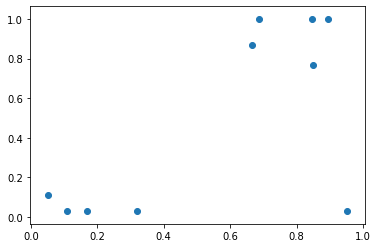

In [21]:
plt.scatter(second_arm_probs, second_arm_choices)

In [24]:
env = gym.make('Bandits-v0', num_arms=3)

In [29]:
env.step(2)

(array([0., 0., 1., 1., 5.]), 1, False, {})

In [30]:
env.reward_probabilities

array([0.32455324, 0.33017026, 0.3452765 ])